In [ ]:
!pip install faker

In [ ]:
def select_data(db_file_path, db_data, reverse=False, verbose=0):
    import sqlite3
    from contextlib import closing
    with closing(sqlite3.connect(db_file_path)) as conn:
        with closing(conn.cursor()) as cur:
            col_dicts = {"n_estimator": (db_data[1], True),
                         "data_length": (db_data[2], True),
                         "random_state": (db_data[3], True),
                         "rounds": (db_data[4], False)
                         }
            where_list = []
            for col in col_dicts:
                if col_dicts[col][1]:
                    where_list.append(f'{col}={col_dicts[col][0]}')
                else:
                    where_list.append(f'{col}=\"{col_dicts[col][0]}\"')
            results = []
            query = f'select * from rndforest where {" and ".join(where_list)}'
            query += " order by id desc" if reverse else " order by id asc"
            if verbose > 0:
                print('query=', query)
            datas = cur.execute(query).fetchall()
            for data in datas:
                results.append(data)
            return results


def insert_data(db_file_path, db_data, auto_commit=True, verbose=0):
    """ insert_randomforest_db """
    import sqlite3
    from contextlib import closing
    from datetime import datetime
    with closing(sqlite3.connect(db_file_path)) as conn:
        col_dicts = {"n_estimator": db_data[1],
                     "data_length": db_data[2],
                     "random_state": db_data[3],
                     "rounds": db_data[4],
                     "matched_cnts": db_data[5],
                     "sum_val": db_data[6],
                     "version": db_data[7]+"_back"
                     }
        columns = col_dicts.keys()
        values=list(col_dicts.values())
        column_val=["?" for i in range(len(columns))]
        query = f"INSERT INTO rndforest ({','.join(columns)}) "\
        f"VALUES ({','.join(column_val)})"
        with closing(conn.cursor()) as cursor:
            if verbose > 0:
                print(f'query={query}')
                print('-'*30)
            cursor.execute(query, values)
            if auto_commit:
                conn.commit()

def backup_randomforest_db(db_file_path, db_datas, auto_commit=True, verbose=0):
    for db_data in db_datas:
        if verbose > 0:
            print('db_data = ', db_data)
        result = select_data(db_file_path, db_data, verbose=verbose)
        if len(result) == 0:
            insert_data(db_file_path, db_data, verbose=verbose)

In [ ]:
from contextlib import closing
verbose = 0
run_this_0 = False
if run_this_0:
    with closing(open('../db/1.txt', 'r')) as fd:
        print('step.0')
        lines = fd.readlines()
        datas = []
        for line in lines:
            line = line.replace('\n', '')
            datas.append(line.split('|'))
            if verbose > 0:
                print(line.split('|'))
        backup_randomforest_db(db_file_path='../db/metrics.db', db_datas = datas, verbose=1)

In [ ]:

!echo "select * from rndforest where version=\"T_01_08_back\" and matched_cnts like '%3%3%3%3%3%';" | sqlite3 ../db/metrics.db

In [ ]:
!echo "select * from rndforest where version=\"T_01_08_back\" and matched_cnts like '%3%3%3%3%3%';" | sqlite3 ../db/metrics.db

In [ ]:
def db_row_parse(rows):
    """ db_row_parse """
    rows_list = []
    for row in rows:
        cols = row.split('|')
        col_dict = {
            "n_estimator": cols[1],
            "data_length": cols[2],
            "random_state": cols[3],
            "rounds": cols[4],
            "matched_cnts": cols[5],
            "sum_val": cols[6],
            "version": cols[7]
            }
        rows_list.append(col_dict)
    return rows_list


def execute_direct_query_for_sum_val_frequency(min_cnt, max_cnt, target_num, version, verbose=0):
    """ execute_direct_query_for_sum_val_frequency """
    likes = ""
    results = {}
    ## base
    for i in range(1, min_cnt):
        likes += f"%{target_num}"
    for i in range(min_cnt, max_cnt+1):
        likes += f"%{target_num}"
        if verbose > 0:
            !echo "{'-'*15} {target_num}'s num = {i} {'-'*15}"
        if verbose > 0:
            !echo "select * from rndforest where version=\"{version}\" and matched_cnts like \"{likes}%\" order by sum_val desc"
        rows = !echo "select * from rndforest where version=\"{version}\" and matched_cnts like \"{likes}%\" order by sum_val desc" | sqlite3 ../db/metrics.db
        rows_list = db_row_parse(rows)
        results[i] = rows_list
    return results


def print_colums(target_num, results, list_view=False):
    for cnt in results:
        print(f"{'-'*15} {target_num}'s num = {cnt} {'-'*15}")
        for row in results[cnt]:
            if list_view:
                print(list(row.values()))
            else:
                print(row)


def db_query(min_cnt, max_cnt, target_num, version, print_data=False, list_view=False, verbose=0):
    """ db_query """
    results = execute_direct_query_for_sum_val_frequency(min_cnt=min_cnt, max_cnt=max_cnt, target_num=target_num, version=version, verbose=verbose)
    if print_data:
        print_colums(target_num, results, list_view)
    return results

In [ ]:
# 3이 많이 발생하는 경우 확인
run_this_3 = False
if run_this_3:
    min_cnt = 3
    max_cnt = 7
    target_num = 3
    version = "T_01_08_back"
    results3_T01_08_back = db_query(min_cnt=min_cnt, max_cnt=max_cnt, version=version, target_num=target_num, print_data=True, list_view=True)

In [ ]:
# 3이 많이 발생하는 경우 확인
min_cnt = 0
max_cnt = 7
target_num = 3
version = "T_01_08"
results3_T01_08 = db_query(min_cnt=min_cnt, max_cnt=max_cnt, version=version, target_num=target_num, print_data=True, list_view=True)

In [ ]:
# 4가 많이 발생하는 경우 확인
min_cnt = 2
max_cnt = 7
target_num = 4
# versions = ["T_01_08_back", "T_01_08"]
versions = ["T_01_08"]
results_dict4 = {}
for version in versions:
    print(f'\n{"*"*15} Checking version = [{version}] {"*"*15}\n')
    results = db_query(min_cnt=min_cnt, max_cnt=max_cnt, version=version, target_num=target_num, print_data=True, list_view=True)
    results_dict4[version] = results

In [ ]:
# 5/6이 많이 발생하는 경우 확인
min_cnt = 1
max_cnt = 3
target_nums = [5, 6]
# versions = ["T_01_08_back", "T_01_08"]
versions = ["T_01_08"]
results_dict5 = {}
for version in versions:
    results_dict5[version] = {}
    for target_num in target_nums:
        print(f'\n{"*"*15} Checking version = [{version} / {target_num}] {"*"*15}\n')
        results = db_query(min_cnt=min_cnt,
                           max_cnt=max_cnt,
                           version=version,
                           target_num=target_num,
                           print_data=True,
                           list_view=True)
        results_dict5[version][target_num] = results

In [ ]:
# find n_estimators=[25, 10]
#  data_lengths = [40]
#  random_state_gap = 1
#  last_rounds = [1176]
!echo "select * from rndforest where version=\"T_01_03\" and sum_val > 14;" | sqlite3 ../db/metrics.db
!echo "...........like 4.............................."
!echo "select * from rndforest where version in (\"T_01_03\", \"T_01_07\") and matched_cnts like \"%4%\";" | sqlite3 ../db/metrics.db
!echo "...........like 5.............................."
!echo "select * from rndforest where version in (\"T_01_03\", \"T_01_07\") and matched_cnts like \"%5%\";" | sqlite3 ../db/metrics.db
!echo "...........like 6.............................."
!echo "select * from rndforest where version in (\"T_01_03\", \"T_01_07\") and matched_cnts like \"%6%\";" | sqlite3 ../db/metrics.db
!echo "..............................................."
!echo "select * from rndforest where version in (\"T_01_07\", \"T_01_03\") and sum_val > 13;" | sqlite3 ../db/metrics.db
!echo "..............................................."


In [ ]:
# find n_estimators=[25, 10]
#  data_lengths = [40]
#  random_state_gap = 1
#  last_rounds = [1176]
version="T_01_05"
!echo "select * from rndforest where version=\"T_01_03\" and random_state in (357, 264, 762, 864);" | sqlite3 ../db/metrics.db
!echo "select * from rndforest where version=\"T_01_06\" and sum_val > 2;" | sqlite3 ../db/metrics.db

In [ ]:
# find n_estimators=[25, 10]
#  data_lengths = [40]
#  random_state_gap = 1
#  last_rounds = [1176, 1175]
version="T_01_05"
!echo "select * from rndforest where version=\"T_01_05\" and sum_val > 3;" | sqlite3 ../db/metrics.db

In [ ]:
# find n_estimators=[25, 10]
#  data_lengths = [40]
#  random_state_gap = 1
#  last_rounds = [1176, 1175, 1174]
!echo "select * from rndforest where version=\"T_01_04\" and sum_val > 5;" | sqlite3 ../db/metrics.db

In [ ]:
# find n_estimators=[25, 10]
#  data_lengths = [40]
#  random_state_gap = 1
#  last_rounds = [1176, 1175, 1174, 1173]
!echo "select * from rndforest where version=\"T_01_02\" and sum_val > 7;" | sqlite3 ../db/metrics.db

In [ ]:
old_versions = ["T_01_01", "T_01_02", "T_01_03", "T_01_04", "T_01_05"]
sum_val = 7
for version in old_versions:
    !echo "select * from rndforest where version=\"{version}\" and sum_val > {sum_val};" | sqlite3 ../db/metrics.db

In [ ]:
!echo "select * from rndforest where version=\"T_01_03\" and random_state=762;" | sqlite3 ../db/metrics.db
!echo "........................................."
!echo "select * from rndforest where version=\"T_01_03\" and sum_val > 12;" | sqlite3 ../db/metrics.db

In [49]:
import itertools
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import random
from faker import Factory

def draw_datas_graph(title,
                     x_y_datas,
                     x_label,
                     y_label,
                     width=0,
                     height=0,
                     file_name="",
                     is_bar=True,
                     verb=False):
    """ draw_data_graph """
    fake = Factory.create()
    for x_y_data in x_y_datas:
        if is_bar:
            if len(x_y_data) > 2:
                plt.bar(x_y_data[0], x_y_data[1], color=fake.hex_color(), label=x_y_data[2])
            else:
                plt.bar(x_y_data[0], x_y_data[1], color=fake.hex_color())
        else:
            if len(x_y_data) > 2:
                plt.plot(x_y_data[0], x_y_data[1], color=fake.hex_color(), label=x_y_data[2])
            else:
                plt.plot(x_y_data[0], x_y_data[1], color=fake.hex_color())
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.title(title)
    if len(file_name) > 0:
        plt.legend(loc=0)
        plt.savefig(file_name)
    if width > 0 and height > 0:
        plt.figure(figsize=(width,height))
    plt.show()


In [91]:
"""
"""
def data_graph_from_db(version: str, random_states: list, verbose=0):
    DB_FILE="../db/metrics.db"

    if len(random_states) == 0:
        wheres = ""
    else:
        temp = [str(i) for i in random_states]
        wheres = f'and random_state in ({",".join(temp)})'
    rows = !echo "select * from rndforest where version=\"{version}\" {wheres} order by random_state asc" | sqlite3 {DB_FILE}

    x_y_datas = []
    for row in rows:
        cols = row.split("|")
        n_estimator = cols[1]
        data_length = cols[2]
        random_state = cols[3]
        rounds = [int(i) for i in cols[4].split(',')]
        matched_cnts = [int(i) for i in cols[5].split(',')]
        rounds.reverse()
        matched_cnts.reverse()
        sum_val = cols[6]
        x_y_datas.append((rounds, matched_cnts, str(random_state)))
        # print(f'{n_estimator} / {data_length} / {random_state} / {sum_val}')
        if verbose > 0:
            print('rounds', rounds)
            print('matched_cnts', matched_cnts)

    # ## predict data
    # file_name = "img/temp.png"
    draw_datas_graph(title="matched_cnts",
                     x_y_datas=x_y_datas,
                     x_label="rounds",
                     y_label="matched_cnts",
                     width=0,
                     height=0,
                     file_name="",
                     is_bar=False,
                     verb=False if verbose == 0 else True)


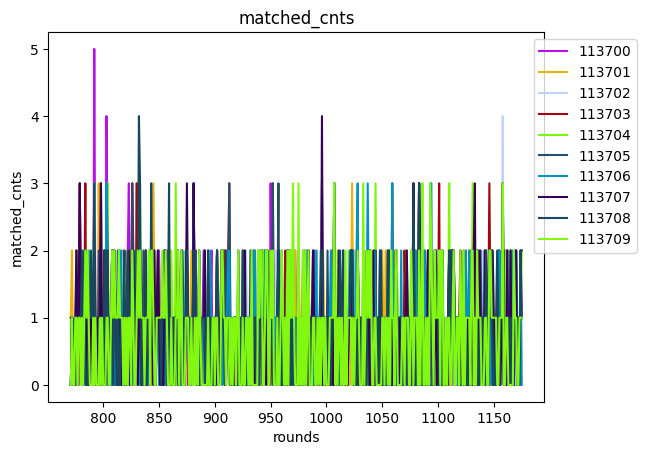

In [111]:
T_VERSION="T_01_10"
random_states = [i for i in range(113690, 113710, 1)]
data_graph_from_db(version=T_VERSION, random_states=random_states,verbose=0)

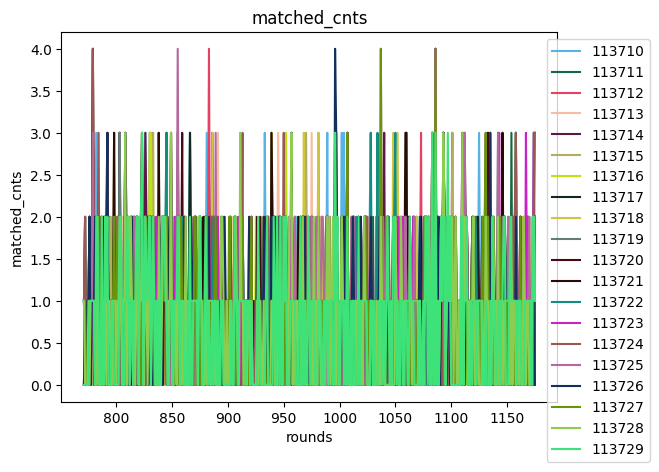

In [110]:
T_VERSION="T_01_10"
random_states = [i for i in range(113710, 113730, 1)]
data_graph_from_db(version=T_VERSION, random_states=random_states,verbose=0)

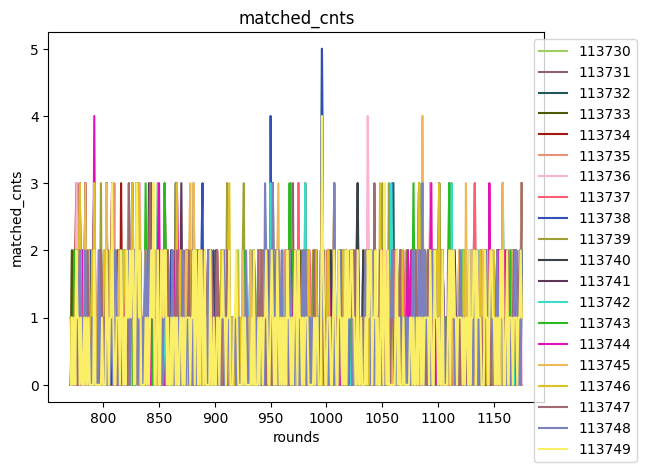

In [109]:
T_VERSION="T_01_10"
random_states = [i for i in range(113730, 113750, 1)]
data_graph_from_db(version=T_VERSION, random_states=random_states,verbose=0)

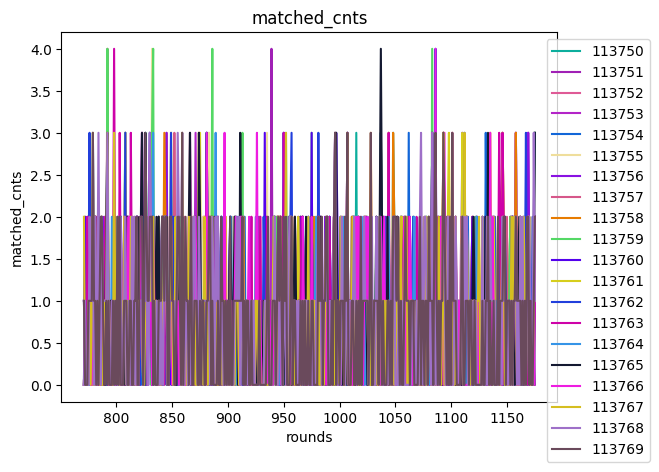

In [104]:
T_VERSION="T_01_10"
random_states = [i for i in range(113750, 113770, 1)]
data_graph_from_db(version=T_VERSION, random_states=random_states,verbose=0)

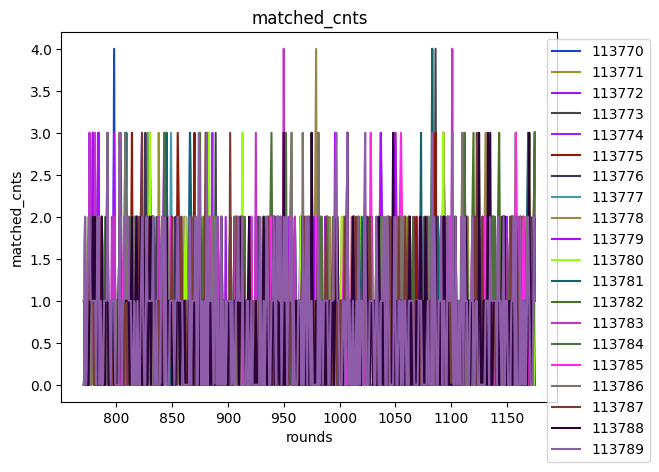

In [105]:
T_VERSION="T_01_10"
random_states = [i for i in range(113770, 113790, 1)]
data_graph_from_db(version=T_VERSION, random_states=random_states,verbose=0)

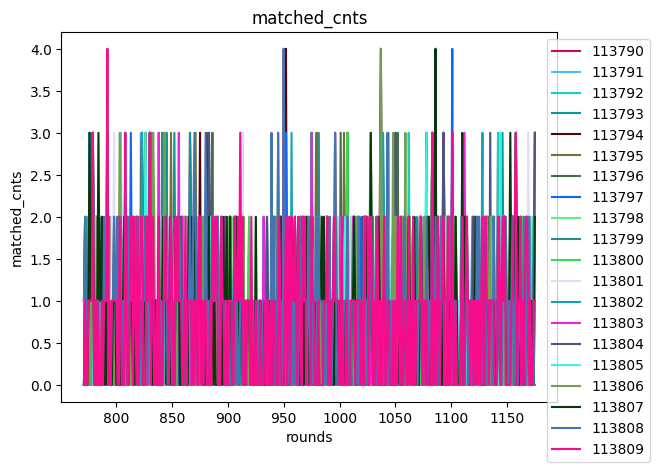

In [106]:
T_VERSION="T_01_10"
random_states = [i for i in range(113790, 113810, 1)]
data_graph_from_db(version=T_VERSION, random_states=random_states,verbose=0)

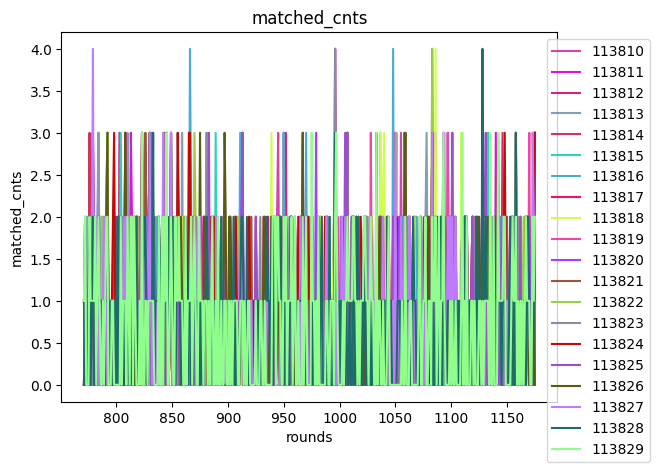

In [107]:
T_VERSION="T_01_10"
random_states = [i for i in range(113810, 113830, 1)]
data_graph_from_db(version=T_VERSION, random_states=random_states,verbose=0)

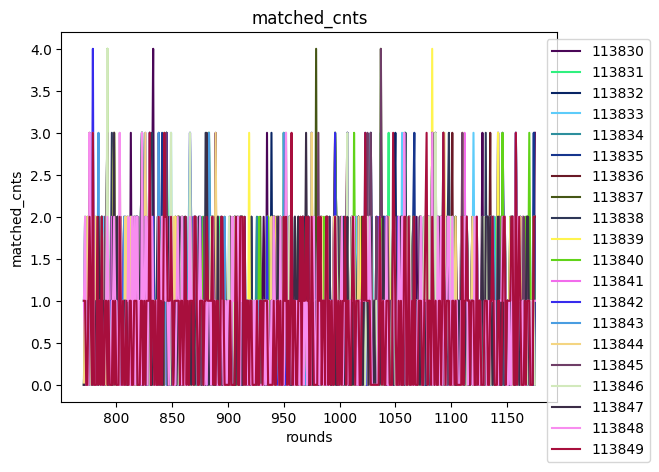

In [108]:
T_VERSION="T_01_10"
random_states = [i for i in range(113830, 113850, 1)]
data_graph_from_db(version=T_VERSION, random_states=random_states,verbose=0)

wheres = and random_state in (113700,113738)
100 / 100 / 113700 / 294
100 / 100 / 113738 / 327


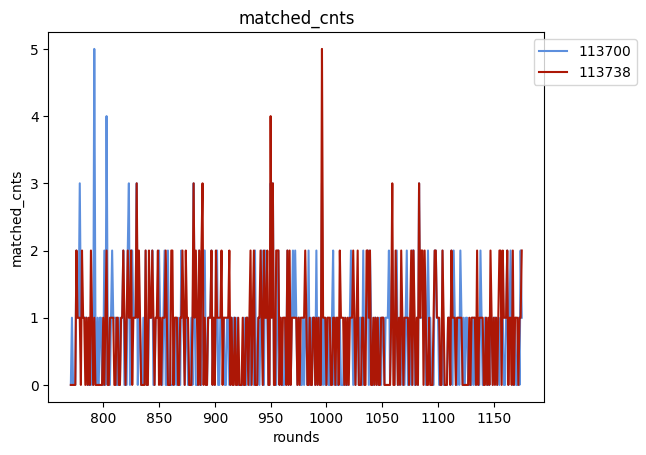

In [88]:
T_VERSION="T_01_10"
# random_states = [114001, 114003, 114005, ]
# random_states = [114005, ]
# random_states = [113723, 113732, 113738]
random_states = [113700, 113738]

data_graph_from_db(version=T_VERSION, random_states=random_states,verbose=0)